In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
#setup the database
engine = create_engine("sqlite:///hawaii.sqlite")
Base = automap_base()


In [20]:
# reflect an existing database into a new model
Base.prepare(engine, reflect=True)

# reflect the tables
Measurement = Base.classes.measurement
Station = Base.classes.station


/Users/rfcelorio/anaconda3/lib/python3.7/site-packages/sqlalchemy/ext/declarative/clsregistry.py:129: SAWarning: This declarative base already contains a class with the same class name and module name as sqlalchemy.ext.automap.measurement, and will be replaced in the string-lookup table.
  % (item.__module__, item.__name__)
/Users/rfcelorio/anaconda3/lib/python3.7/site-packages/sqlalchemy/ext/declarative/clsregistry.py:129: SAWarning: This declarative base already contains a class with the same class name and module name as sqlalchemy.ext.automap.station, and will be replaced in the string-lookup table.
  % (item.__module__, item.__name__)


In [21]:
# We can view all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [22]:
# Save references to each table
Measurement

sqlalchemy.ext.automap.measurement

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Climate Analysis

(array([-500.,    0.,  500., 1000., 1500., 2000., 2500.]),
 <a list of 7 Text xticklabel objects>)

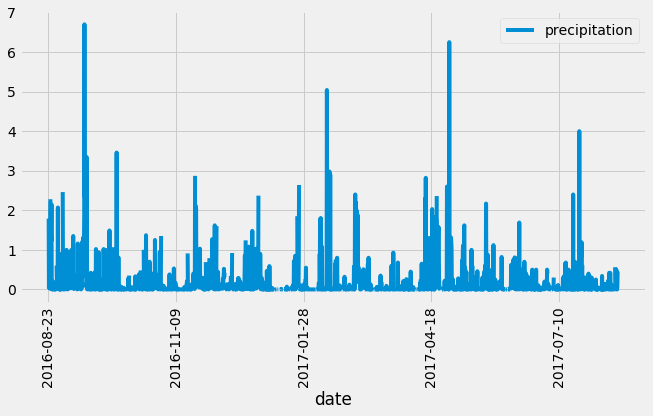

In [76]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
#Starting from the last data point in the database. 

# Calculate the date one year from the last date in data set.
prev_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
results = []
# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= prev_year).all()
#print(results)

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results, columns=['date','precipitation'])
df.set_index(df['date'], inplace=True)

# Sort the dataframe by date
df = df.sort_index()
#print(df.to_string(index=False))

xdates = df["date"]

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(figsize=(10,5))
start, end = ax.get_xlim()

ax = plt.gca()
ax.legend(loc="upper right")
#ax.xaxis.set_ticks(np.arange(start, end, 90))

#plt.xticks(np.arange(df['date'][0], df['date'][len(df["date"]), 8), rotation=90)
plt.xticks(rotation=90)



In [35]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()


,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# How many stations are available in this dataset?


In [13]:
# What are the most active stations?
# List the stations and the counts in descending order.


In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?


In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


In [16]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates


# Challenge